In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
class Backpropagation:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, activation_function='relu'):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.activation_function = activation_function
        
        # Initialize weights and biases
        self.weights_input_hidden1 = np.random.randn(self.input_size, self.hidden_size1)
        self.weights_hidden1_hidden2 = np.random.randn(self.hidden_size1, self.hidden_size2)  # Bobot antara hidden layer 1 dan hidden layer 2
        self.weights_hidden2_output = np.random.randn(self.hidden_size2, self.output_size)  # Bobot antara hidden layer 2 dan output layer
        
        self.bias_hidden1 = np.zeros((1, self.hidden_size1))
        self.bias_hidden2 = np.zeros((1, self.hidden_size2))
        self.bias_output = np.zeros((1, self.output_size))

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))  # Untuk stabilitas numerik
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def feedforward(self, X):
        # Hitung aktivasi hidden layer pertama
        self.hidden1_activation = np.dot(X, self.weights_input_hidden1) + self.bias_hidden1
        self.hidden1_output = self.relu(self.hidden1_activation)  # Aktivasi ReLU
        
        # Hitung aktivasi hidden layer kedua
        self.hidden2_activation = np.dot(self.hidden1_output, self.weights_hidden1_hidden2) + self.bias_hidden2
        self.hidden2_output = self.relu(self.hidden2_activation)  # Aktivasi ReLU
        
        # Hitung output layer
        self.output_activation = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
        if self.activation_function == 'softmax':
            self.predicted_output = self.softmax(self.output_activation)  # Softmax untuk output layer
        else:
            self.predicted_output = self.relu(self.output_activation)  # ReLU untuk output layer

        return self.predicted_output

    def backward(self, X, y, learning_rate):
        # Hitung error dan delta untuk output layer
        if self.activation_function == 'softmax':
            output_error = y - self.predicted_output
            output_delta = output_error  # Cross-entropy loss tidak memerlukan turunan softmax
        else:
            output_error = y - self.predicted_output
            output_delta = output_error * self.relu_derivative(self.predicted_output)

        # Hitung error dan delta untuk hidden layer kedua
        hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)
        hidden2_delta = hidden2_error * self.relu_derivative(self.hidden2_output)

        # Hitung error dan delta untuk hidden layer pertama
        hidden1_error = np.dot(hidden2_delta, self.weights_hidden1_hidden2.T)
        hidden1_delta = hidden1_error * self.relu_derivative(self.hidden1_output)

        # Update bobot dan bias
        self.weights_hidden2_output += np.dot(self.hidden2_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_hidden1_hidden2 += np.dot(self.hidden1_output.T, hidden2_delta) * learning_rate
        self.bias_hidden2 += np.sum(hidden2_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden1 += np.dot(X.T, hidden1_delta) * learning_rate
        self.bias_hidden1 += np.sum(hidden1_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
        
            # Menghitung Cross-Entropy Loss untuk softmax
            if self.activation_function == 'softmax':
                loss = -np.mean(np.sum(y * np.log(output + 1e-9), axis=1))  # Tambahkan epsilon untuk menghindari log(0)
            else:
                loss = np.mean(np.square(y - output))  # Untuk relu
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")

In [3]:
df = pd.read_csv('obesity-dataset-preprocessed.csv')
df.shape

(2063, 21)

Epoch 0, Loss: 14.643455085097665
Epoch 1000, Loss: 0.7655934800445051
Epoch 2000, Loss: 0.7111341587071658
Epoch 3000, Loss: 0.658240672169765
Epoch 4000, Loss: 0.6712478756534118
Epoch 5000, Loss: 0.7379229118249058
Epoch 6000, Loss: 0.6159848341175796
Epoch 7000, Loss: 0.6244794256671223
Epoch 8000, Loss: 0.6127568055436896
Epoch 9000, Loss: 0.6210774311257358
Epoch 10000, Loss: 0.6068096444922324
Epoch 11000, Loss: 0.608136959782866
Epoch 12000, Loss: 0.6525802011107475
Epoch 13000, Loss: 0.6006694685752816
Epoch 14000, Loss: 0.6280528928187559
Epoch 15000, Loss: 0.6332179381499314
Epoch 16000, Loss: 0.6223931204839441
Epoch 17000, Loss: 0.5845025994685595
Epoch 18000, Loss: 0.5890452262301916
Epoch 19000, Loss: 0.5852426683945023
Fold Accuracy: 0.9135247319266689
              precision    recall  f1-score   support

           0       0.61      0.83      0.70        54
           1       0.59      0.28      0.38        57
           2       0.81      0.79      0.80        70
    

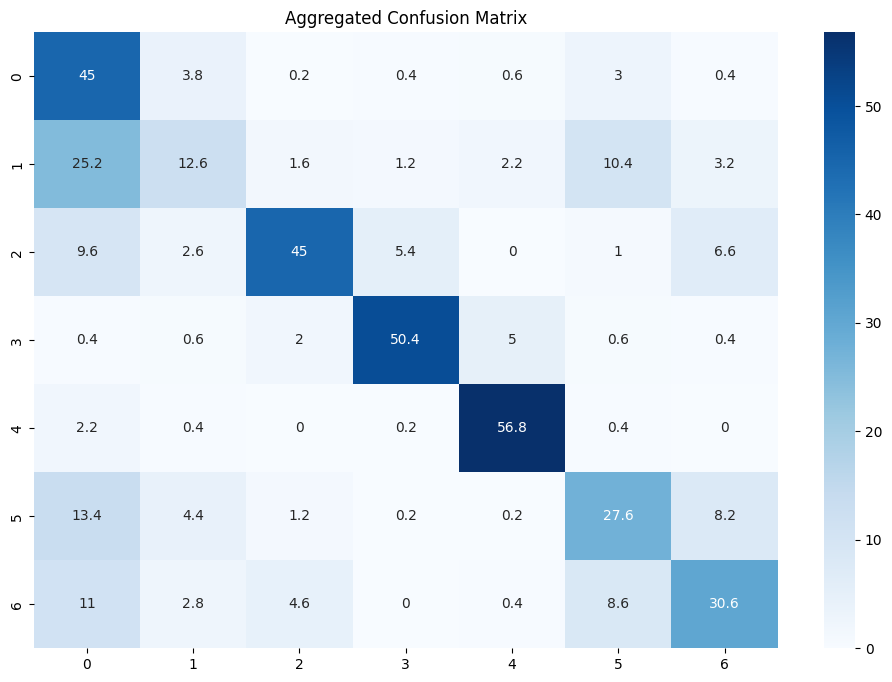

In [4]:
# Memisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Scaling features (Hanya data pelatihan yang di-fit oleh scaler)
scaler = StandardScaler()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size = 10
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Scaling the features (fit scaler only on training data)
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train
    X_test_scaled = scaler.transform(X_test)        # Only transform on test

    # Initialize and train the neural network with ReLU and Softmax
    nn = Backpropagation(input_size, hidden_size, hidden_size, output_size, activation_function='softmax')  # Coba dengan softmax
    nn.train(X_train_scaled, y_train, epochs=20000, learning_rate=0.0005)

    # Generate predictions
    output = nn.feedforward(X_test_scaled)
    output = np.round(output)  # Round output to get 0 or 1

    # Calculate accuracy
    accuracy = np.mean(output == y_test)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    classification_reports.append(classification_report(y_test.argmax(axis=1), output.argmax(axis=1), output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test.argmax(axis=1), output.argmax(axis=1)))

    print(f"Fold Accuracy: {accuracy}")
    print(classification_report(y_test.argmax(axis=1), output.argmax(axis=1)))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Aggregated Confusion Matrix")
plt.show()


Epoch 0, Loss: 646.0390944564494
Epoch 1000, Loss: 0.14285714285714285
Epoch 2000, Loss: 0.14285714285714285
Epoch 3000, Loss: 0.14285714285714285
Epoch 4000, Loss: 0.14285714285714285
Epoch 5000, Loss: 0.14285714285714285
Epoch 6000, Loss: 0.14285714285714285
Epoch 7000, Loss: 0.14285714285714285
Epoch 8000, Loss: 0.14285714285714285
Epoch 9000, Loss: 0.14285714285714285
Epoch 10000, Loss: 0.14285714285714285
Epoch 11000, Loss: 0.14285714285714285
Epoch 12000, Loss: 0.14285714285714285
Epoch 13000, Loss: 0.14285714285714285
Epoch 14000, Loss: 0.14285714285714285
Epoch 15000, Loss: 0.14285714285714285
Epoch 16000, Loss: 0.14285714285714285
Epoch 17000, Loss: 0.14285714285714285
Epoch 18000, Loss: 0.14285714285714285
Epoch 19000, Loss: 0.14285714285714285


c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        54
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        58

    accuracy                           0.13       413
   macro avg       0.02      0.14      0.03       413
weighted avg       0.02      0.13      0.03       413

Epoch 0, Loss: 412.0691163724331
Epoch 1000, Loss: 0.14285714285714285
Epoch 2000, Loss: 0.14285714285714285
Epoch 3000, Loss: 0.14285714285714285
Epoch 4000, Loss: 0.14285714285714285
Epoch 5000, Loss: 0.14285714285714285
Epoch 6000, Loss: 0.14285714285714285
Epoch 7000, Loss: 0.14285714285714285
Epoch 8000, Loss: 0.14285714285714285
Epoch 9000, Loss: 0.142857142857

c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        53
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        58

    accuracy                           0.13       413
   macro avg       0.02      0.14      0.03       413
weighted avg       0.02      0.13      0.03       413

Epoch 0, Loss: 334.8700907762809
Epoch 1000, Loss: 0.14285714285714285
Epoch 2000, Loss: 0.14285714285714285
Epoch 3000, Loss: 0.14285714285714285
Epoch 4000, Loss: 0.14285714285714285
Epoch 5000, Loss: 0.14285714285714285
Epoch 6000, Loss: 0.14285714285714285
Epoch 7000, Loss: 0.14285714285714285
Epoch 8000, Loss: 0.14285714285714285
Epoch 9000, Loss: 0.142857142857

c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        53
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        56
           6       0.00      0.00      0.00        58

    accuracy                           0.13       413
   macro avg       0.02      0.14      0.03       413
weighted avg       0.02      0.13      0.03       413

Epoch 0, Loss: 195.74322817175354
Epoch 1000, Loss: 0.14285714285714285
Epoch 2000, Loss: 0.14285714285714285
Epoch 3000, Loss: 0.14285714285714285
Epoch 4000, Loss: 0.14285714285714285
Epoch 5000, Loss: 0.14285714285714285
Epoch 6000, Loss: 0.14285714285714285
Epoch 7000, Loss: 0.14285714285714285
Epoch 8000, Loss: 0.14285714285714285
Epoch 9000, Loss: 0.14285714285

c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        53
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        58

    accuracy                           0.13       412
   macro avg       0.02      0.14      0.03       412
weighted avg       0.02      0.13      0.03       412

Epoch 0, Loss: 618.6455088211654
Epoch 1000, Loss: 0.14285714285714285
Epoch 2000, Loss: 0.14285714285714285
Epoch 3000, Loss: 0.14285714285714285
Epoch 4000, Loss: 0.14285714285714285
Epoch 5000, Loss: 0.14285714285714285
Epoch 6000, Loss: 0.14285714285714285
Epoch 7000, Loss: 0.14285714285714285
Epoch 8000, Loss: 0.14285714285714285
Epoch 9000, Loss: 0.142857142857

c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\feder\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Fold Accuracy: 0.8571428571428571
              precision    recall  f1-score   support

           0       0.13      1.00      0.23        54
           1       0.00      0.00      0.00        56
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        55
           6       0.00      0.00      0.00        58

    accuracy                           0.13       412
   macro avg       0.02      0.14      0.03       412
weighted avg       0.02      0.13      0.03       412

Average Accuracy: 0.8571428571428571


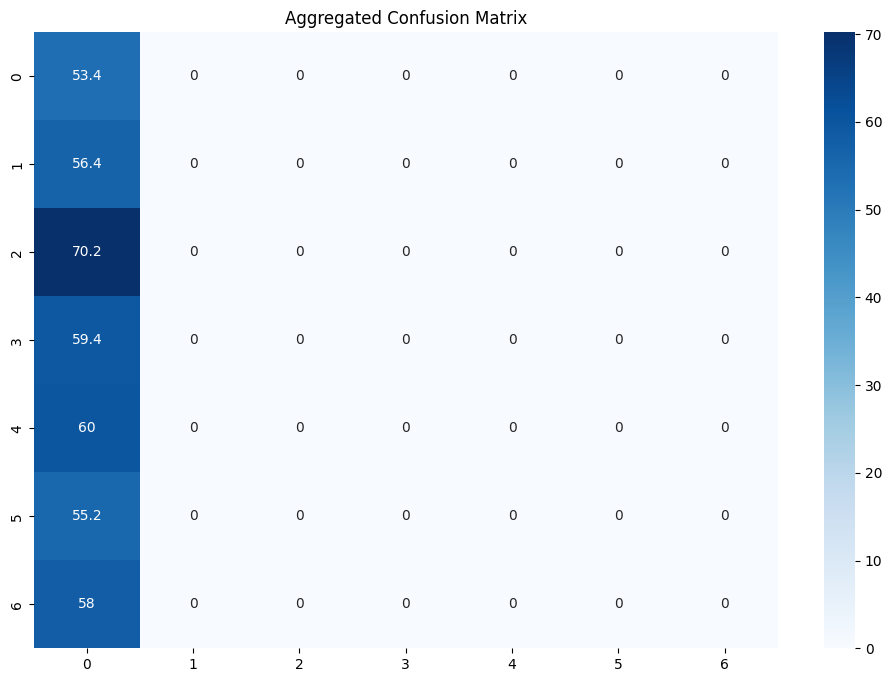

In [7]:
# Memisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Scaling features (Hanya data pelatihan yang di-fit oleh scaler)
scaler = StandardScaler()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size = 20
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Scaling the features (fit scaler only on training data)
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train
    X_test_scaled = scaler.transform(X_test)        # Only transform on test

    # Initialize and train the neural network with ReLU and Softmax
    nn = Backpropagation(input_size, hidden_size, hidden_size, output_size, activation_function= "relu")
    nn.train(X_train_scaled, y_train, epochs=20000, learning_rate=0.0005)

    # Generate predictions
    output = nn.feedforward(X_test_scaled)
    output = np.round(output)  # Round output to get 0 or 1

    # Calculate accuracy
    accuracy = np.mean(output == y_test)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    classification_reports.append(classification_report(y_test.argmax(axis=1), output.argmax(axis=1), output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test.argmax(axis=1), output.argmax(axis=1)))

    print(f"Fold Accuracy: {accuracy}")
    print(classification_report(y_test.argmax(axis=1), output.argmax(axis=1)))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Aggregated Confusion Matrix")
plt.show()
